In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn import metrics, model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [3]:
# Choose a target
target = "NR-AR"

# import the processed dataset for algorithms what require scaled variables
print('Load Pickle')
pickle_in = open(target + "_processeddata.pkl", "rb")
[param, train_smi, test_smi, train_mol_id, test_mol_id,  X_train, X_test, y_train, y_test] = pickle.load(pickle_in)
pickle_in.close()
print('Finished')

# standardization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Load Pickle
Finished


We generate a random forest classifier in the full feature space

In [4]:
# generate a random forest model
rf = RandomForestClassifier(n_estimators=500, random_state=100)
rf.fit(X_train, y_train)

print('Make predictions')
y_pred_train = rf.predict(X_train) # make predictions for the training set
y_pred_test = rf.predict(X_test) # make predictions for the test set
print('Finished')

Make predictions
Finished


Calculate performance metrics for the model

In [5]:
# Evaluate the model: calculate the evaluation metrics
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

       | accuracy | sensitivity | specificity | precision 
train  |   1.00   |     1.00    |    1.00     |   1.00
test   |   0.97   |     0.40    |    1.00     |   0.89

train F1-Score: 1.00
test F1-Score: 0.56


Notice the accuracy, sensitivity and f1-score are very close to those of the kNN baseline model.  

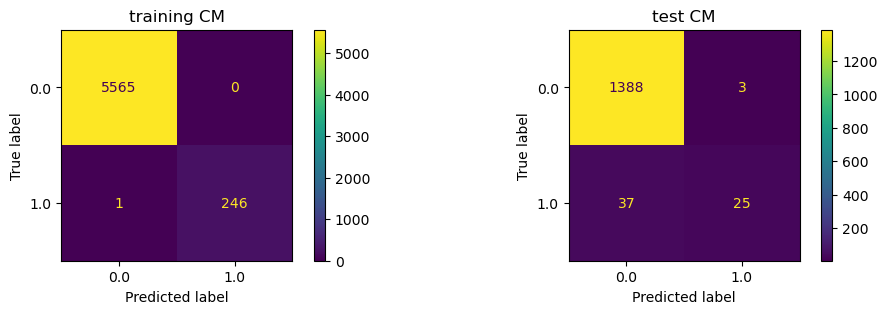

In [6]:
# plot the confusion matrices for training and test sets
fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
# confusion matrix of the training set as the second subplot
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_train,y_pred_train, ax=ax3)
# set the title for the subplot
ax3.title.set_text('training CM')
# confusion matrix of the test set as the third subplot
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test, ax=ax4)
ax4.title.set_text('test CM')

train ROC-AUC: 1.00
test ROC-AUC: 0.79
train PR-AUC: 1.00
test PR-AUC: 0.51


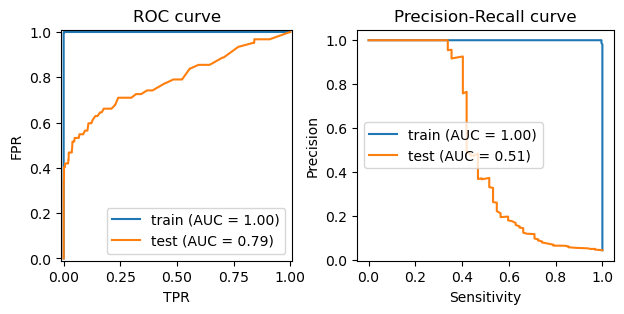

In [7]:
# create a figurespace with 3 subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7.3, 3))

# ROC-AUC plots as the first subplot
y_train_prob = rf.predict_proba(X_train)[:,1]
print(f'train ROC-AUC: {metrics.roc_auc_score(y_train, y_train_prob):.2f}')
y_test_prob = rf.predict_proba(X_test)[:,1]
print(f'test ROC-AUC: {metrics.roc_auc_score(y_test, y_test_prob):.2f}')
metrics.RocCurveDisplay.from_predictions(y_train, y_train_prob, name="train", ax=ax1)
metrics.RocCurveDisplay.from_predictions(y_test,y_test_prob, name="test", ax=ax1)
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')
ax1.title.set_text('ROC curve')

precision_curve_train, recall_curve_train, _ = metrics.precision_recall_curve(y_train, y_train_prob)
print(f'train PR-AUC: {metrics.auc(recall_curve_train, precision_curve_train):.2f}')
precision_curve_test, recall_curve_test, _ = metrics.precision_recall_curve(y_test, y_test_prob)
print(f'test PR-AUC: {metrics.auc(recall_curve_test, precision_curve_test):.2f}')
# plot PR curves
ax2.plot(recall_curve_train, precision_curve_train, label='train (AUC = %0.2f)' % metrics.auc(recall_curve_train, precision_curve_train))
ax2.plot(recall_curve_test, precision_curve_test, label='test (AUC = %0.2f)' % metrics.auc(recall_curve_test, precision_curve_test))
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.title.set_text('Precision-Recall curve')

We now perform Hyperparameter tuning to look for the best hyperparameters. We use 'f1' scoring to compromise between sensitivity and precision.

In [8]:
from sklearn.model_selection import GridSearchCV

# Define a stratified k-fold cross-validation (to maintain class balance in each fold)
cv = model_selection.StratifiedKFold(n_splits=5)

# Define the parameter grid
param_grid = {
 #   'n_estimators': [100, 200, 300],         # Try different numbers of trees
    'max_depth': [None, 5, 10, 15],         # Try limiting tree depth
    'min_samples_split': [2, 5, 10],         # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],           # Minimum samples in a leaf
    'class_weight': ['balanced', None]       # Adjust class weights
 #   'max_features': ['auto', 'sqrt'],        # Number of features considered for each split
 #   'bootstrap': [True, False]               # Whether to bootstrap samples
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=100, n_estimators=200), param_grid, cv=cv, scoring='f1', n_jobs=2)
grid_rf.fit(X_train, y_train)

print("Best parameters found: ", grid_rf.best_params_)
print("Best score found: ", grid_rf.best_score_)
# retrieve the information
hyperparam_combi = grid_rf.cv_results_['params']
C_test_score = grid_rf.cv_results_['mean_test_score']
# print results for each model in the search
for i in range(len(hyperparam_combi)):
    print(f"Hyperparameters: {hyperparam_combi[i]} gave a score of {C_test_score[i]:.4f}")

Best parameters found:  {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best score found:  0.6122375706708633
Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2} gave a score of 0.6083
Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5} gave a score of 0.6089
Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10} gave a score of 0.6046
Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2} gave a score of 0.6115
Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5} gave a score of 0.6083
Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10} gave a score of 0.6073
Hyperparameters: {'class_weight

       | accuracy | sensitivity | specificity | precision 
train  |   1.00   |     1.00    |    1.00     |   0.92
test   |   0.97   |     0.39    |    1.00     |   0.83

train F1-Score: 0.96
test F1-Score: 0.53
train ROC-AUC: 1.00
test ROC-AUC: 0.77
train PR-AUC: 0.96
test PR-AUC: 0.48


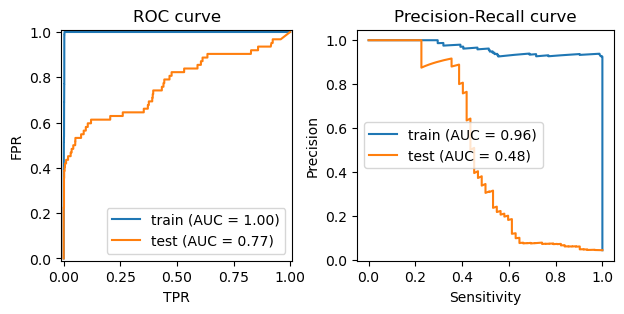

In [9]:
# Recalculate the prediction with the best hyperparameters
y_pred_train = grid_rf.predict(X_train) # make predictions for the training set
y_pred_test = grid_rf.predict(X_test) # make predictions for the test set

# Evaluate the model: calculate the evaluation metrics
acc_train = metrics.accuracy_score(y_train, y_pred_train)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
sens_train = metrics.recall_score(y_train, y_pred_train, pos_label=1)
sens_test = metrics.recall_score(y_test, y_pred_test, pos_label=1)
spec_train = metrics.recall_score(y_train, y_pred_train, pos_label=0)
spec_test = metrics.recall_score(y_test, y_pred_test, pos_label=0)
prec_train = metrics.precision_score(y_train, y_pred_train, pos_label=1)
prec_test = metrics.precision_score(y_test, y_pred_test, pos_label=1)

# print the evaluation metrics in a formatted manner
print("       | accuracy | sensitivity | specificity | precision ")
print(f"train  |   {acc_train:.2f}   |     {sens_train:.2f}    |    {spec_train:.2f}     |   {prec_train:.2f}")
print(f"test   |   {acc_test:.2f}   |     {sens_test:.2f}    |    {spec_test:.2f}     |   {prec_test:.2f}")

# calculate the F1-Score
precision_train, recall_train, f1_score_train, _ = metrics.precision_recall_fscore_support(y_train, y_pred_train, average='binary')
precision_test, recall_test, f1_score_test, _ = metrics.precision_recall_fscore_support(y_test, y_pred_test, average='binary')

print(f'\ntrain F1-Score: {f1_score_train:.2f}')
print(f'test F1-Score: {f1_score_test:.2f}')

# create a figurespace with 3 subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7.3, 3))

# ROC-AUC plots as the first subplot
y_train_prob = grid_rf.predict_proba(X_train)[:,1]
print(f'train ROC-AUC: {metrics.roc_auc_score(y_train, y_train_prob):.2f}')
y_test_prob = grid_rf.predict_proba(X_test)[:,1]
print(f'test ROC-AUC: {metrics.roc_auc_score(y_test, y_test_prob):.2f}')
metrics.RocCurveDisplay.from_predictions(y_train, y_train_prob, name="train", ax=ax1)
metrics.RocCurveDisplay.from_predictions(y_test,y_test_prob, name="test", ax=ax1)
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')
ax1.title.set_text('ROC curve')

precision_curve_train, recall_curve_train, _ = metrics.precision_recall_curve(y_train, y_train_prob)
print(f'train PR-AUC: {metrics.auc(recall_curve_train, precision_curve_train):.2f}')
precision_curve_test, recall_curve_test, _ = metrics.precision_recall_curve(y_test, y_test_prob)
print(f'test PR-AUC: {metrics.auc(recall_curve_test, precision_curve_test):.2f}')
# plot PR curves
ax2.plot(recall_curve_train, precision_curve_train, label='train (AUC = %0.2f)' % metrics.auc(recall_curve_train, precision_curve_train))
ax2.plot(recall_curve_test, precision_curve_test, label='test (AUC = %0.2f)' % metrics.auc(recall_curve_test, precision_curve_test))
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.title.set_text('Precision-Recall curve')

Once again, the performance on the test set is virtually unchanged as compared to kNN. We check how the scores vary when doing cross-validation using stratified k-fold to maintain class balance in each fold:

In [10]:
# Define a stratified k-fold cross-validation (to maintain class balance in each fold)
cv = model_selection.StratifiedKFold(n_splits=5)

# Custom scoring for F1, Precision, Recall, AUC-PR
scoring = {
    'precision': metrics.make_scorer(metrics.precision_score),
    'recall': metrics.make_scorer(metrics.recall_score),
    'f1': metrics.make_scorer(metrics.f1_score),
    'auc_pr': metrics.make_scorer(metrics.average_precision_score),  # For AUC-PR
    'roc_auc': 'roc_auc'  # For AUC-ROC
}

# Perform cross-validation and evaluate scores
cv_results = model_selection.cross_validate(grid_rf, X_train, y_train, cv=cv, scoring=scoring)


for metric in scoring.keys():
    print(f"{metric}: {cv_results[f'test_{metric}']}")

precision: [0.88461538 0.81481481 0.90322581 0.8        0.84375   ]
recall: [0.46       0.44       0.57142857 0.40816327 0.55102041]
f1: [0.60526316 0.57142857 0.7        0.54054054 0.66666667]
auc_pr: [0.4301389  0.38259418 0.53420132 0.35148758 0.48385634]
roc_auc: [0.81297394 0.80609164 0.81868273 0.78077269 0.83260905]


In [12]:
for metric in scoring.keys():
    print(f"{metric}: {cv_results[f'test_{metric}'].mean():.2f} +/- {cv_results[f'test_{metric}'].std():.2f}")

precision: 0.85 +/- 0.04
recall: 0.49 +/- 0.06
f1: 0.62 +/- 0.06
auc_pr: 0.44 +/- 0.07
roc_auc: 0.81 +/- 0.02


The high variation over the folds in these metrics indicate the logistic regression models are not ready to be generalized. This could be caused by overfitting of the model for the minority class because of the imbalance in the dataset (i.e. too little data on toxic molecules). 

For the best model, we can print out the most important features:

In [11]:
best_rf = grid_rf.best_estimator_
feature_importances = best_rf.feature_importances_
feat_imp_df = pd.DataFrame({'feature': param, 'importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
print(feat_imp_df.head(15))

                     feature  importance
82         NumAliphaticRings    0.033752
5                        SPS    0.032372
26                     Chi4n    0.031417
81   NumAliphaticCarbocycles    0.031065
122              fr_bicyclic    0.027232
56                SlogP_VSA4    0.026794
27                     Chi4v    0.021567
47                  SMR_VSA4    0.020495
22                     Chi2n    0.019793
15                   BertzCT    0.019182
24                     Chi3n    0.019159
90   NumSaturatedCarbocycles    0.017499
13                    AvgIpc    0.015701
12          FpDensityMorgan3    0.015531
48                  SMR_VSA5    0.015525
